### import important packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np

import os
import sys

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from LoadRealRunningJumping import *
from LoadSyntheticRunningJumping import *

from GANModels import *

from dataLoader import *

import torch.fft as fft
from torchsummary import summary

from EvaluationFunctions import EncoderEvaluation

from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# Encoder Study

## Load data and GAN generator and discriminator from checkpoint

In [2]:
models_path = '../pre-trained-models/daghar_split_dataset/seq_len_30/3axis/'
data_path = '../DAGHAR_split_25_10/train/data/KuHar_DAGHAR_Multiclass.csv'
label_path = '../DAGHAR_split_25_10/train/label/KuHar_Label_Multiclass.csv'

original_set = daghar_load_dataset_with_label(class_name= "kuhar",
                                              seq_len=30,
                                              data_path=data_path,
                                              label_path=label_path,
                                              channels=3)

gen_model = Generator(seq_len=30, channels=3).cuda()
running_model = Discriminator(seq_len=30, in_channels=3)
running_ckp = torch.load(models_path + 'KuHar_DAGHAR_Multiclass_50000_D_30_2024_10_25_02_42_43/Model/checkpoint')
running_model.load_state_dict(running_ckp['dis_state_dict'])

return single class data and labels, class is kuhar
data shape is (2784, 3, 1, 30)
label shape is (2784,)


/tmp/ipykernel_21511/1496774067.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  running_ckp = torch.load(models_path + 'KuHar_DAGHAR_Multiclass_50000_D_30_2024_10_25_02

<All keys matched successfully>

In [3]:
summary(gen_model, (1, 3, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 3, 300]          30,300
         LayerNorm-2               [-1, 30, 10]              20
            Linear-3               [-1, 30, 10]             110
            Linear-4               [-1, 30, 10]             110
            Linear-5               [-1, 30, 10]             110
           Dropout-6            [-1, 5, 30, 30]               0
            Linear-7               [-1, 30, 10]             110
MultiHeadAttention-8               [-1, 30, 10]               0
           Dropout-9               [-1, 30, 10]               0
      ResidualAdd-10               [-1, 30, 10]               0
        LayerNorm-11               [-1, 30, 10]              20
           Linear-12               [-1, 30, 40]             440
             GELU-13               [-1, 30, 40]               0
          Dropout-14               [-1,

In [4]:
model = Discriminator(seq_len=30, in_channels=3).cuda()
summary(model, (3, 1, 30))

AttributeError: 'ClassificationHead' object has no attribute 'Reduce'

## Set discriminator to encoder

In [ ]:
keys_to_remove = list(running_ckp['dis_state_dict'].keys())[-4:]  # Obtém as últimas 4 chaves

print(f"original keys: {running_ckp['dis_state_dict'].keys()}")
# Remove as chaves do dicionário original
for key in keys_to_remove:
    del running_ckp['dis_state_dict'][key]

# Verificando o resultado
print(f"ajusted keys: {running_ckp['dis_state_dict'].keys()}")

original keys: odict_keys(['0.cls_token', '0.positions', '0.projection.1.weight', '0.projection.1.bias', '1.0.0.fn.0.weight', '1.0.0.fn.0.bias', '1.0.0.fn.1.keys.weight', '1.0.0.fn.1.keys.bias', '1.0.0.fn.1.queries.weight', '1.0.0.fn.1.queries.bias', '1.0.0.fn.1.values.weight', '1.0.0.fn.1.values.bias', '1.0.0.fn.1.projection.weight', '1.0.0.fn.1.projection.bias', '1.0.1.fn.0.weight', '1.0.1.fn.0.bias', '1.0.1.fn.1.0.weight', '1.0.1.fn.1.0.bias', '1.0.1.fn.1.3.weight', '1.0.1.fn.1.3.bias', '1.1.0.fn.0.weight', '1.1.0.fn.0.bias', '1.1.0.fn.1.keys.weight', '1.1.0.fn.1.keys.bias', '1.1.0.fn.1.queries.weight', '1.1.0.fn.1.queries.bias', '1.1.0.fn.1.values.weight', '1.1.0.fn.1.values.bias', '1.1.0.fn.1.projection.weight', '1.1.0.fn.1.projection.bias', '1.1.1.fn.0.weight', '1.1.1.fn.0.bias', '1.1.1.fn.1.0.weight', '1.1.1.fn.1.0.bias', '1.1.1.fn.1.3.weight', '1.1.1.fn.1.3.bias', '1.2.0.fn.0.weight', '1.2.0.fn.0.bias', '1.2.0.fn.1.keys.weight', '1.2.0.fn.1.keys.bias', '1.2.0.fn.1.queries.weigh

In [ ]:
class Encoder(nn.Sequential):
    def __init__(self, 
                 in_channels=3,
                 patch_size=15,
                 emb_size=50, 
                 seq_len = 150,
                 depth=3, 
                 n_classes=1, 
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_len),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs)
        )

In [ ]:
encoder = Encoder(in_channels=3, seq_len=30).cuda()
summary(encoder, (3, 1, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1                [-1, 2, 45]               0
            Linear-2                [-1, 2, 50]           2,300
PatchEmbedding_Linear-3                [-1, 3, 50]               0
         LayerNorm-4                [-1, 3, 50]             100
            Linear-5                [-1, 3, 50]           2,550
            Linear-6                [-1, 3, 50]           2,550
            Linear-7                [-1, 3, 50]           2,550
           Dropout-8              [-1, 5, 3, 3]               0
            Linear-9                [-1, 3, 50]           2,550
MultiHeadAttention-10                [-1, 3, 50]               0
          Dropout-11                [-1, 3, 50]               0
      ResidualAdd-12                [-1, 3, 50]               0
        LayerNorm-13                [-1, 3, 50]             100
           Linear-14               

In [ ]:
encoder.load_state_dict(running_ckp['dis_state_dict'])

<All keys matched successfully>

In [ ]:
samples = torch.from_numpy(original_set[:][0]).float().to('cuda')
labels = torch.from_numpy(original_set[:][1])
print(samples.shape)
forward = encoder(samples)
print(forward.shape)

torch.Size([2784, 3, 1, 30])
torch.Size([2784, 3, 50])


In [ ]:
def TSNE_visualization(data, labels, title='t-SNE plot', show=True, save_path=''):
    '''

    Espera-se que os dados originais estejam na forma (batch, channels, timeframe), por exemplo, (2784, 3, 50)
    
    '''
    colors = [
        "#FF5733",  # Vermelho
        "#337BFF",  # Azul
        "#33FF57",  # Verde
        "#FFD133",  # Amarelo
        "#9B33FF",  # Roxo
        "#33FFF6"   # Ciano
        ]
    actions = ['sit', 'stand', 'walk', 'upstairs', 'downstairs', 'run']

    # Garantir que os dados são numpy array e embaralhar com labels
    data = np.asarray(data)
    labels = np.asarray(labels)
    l = len(data)
    idx = np.random.permutation(l)
    data, labels = data[idx], labels[idx]

        # Pré-processamento: média ao longo da dimensão dos canais (dim=1)
        # Para cada batch, reduzimos para uma representação média de forma (2784, 50)
    prep = np.mean(data, axis=1)
    print("Shape após a média por canal:", prep.shape)

    # Análise TSNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(prep)
    print("Shape do resultado TSNE:", tsne_results.shape)

    # Plotagem
    if not show:
        return tsne_results

    f, ax = plt.subplots(1, figsize=(12,6))

    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                          c=[colors[label] for label in labels], alpha=0.6)
        # Criar uma legenda customizada para as classes
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(actions))]
    ax.legend(handles, actions, title="Actions")

    ax.set_title(title)
    ax.set_xlabel('x-tsne')
    ax.set_ylabel('y-tsne')
    if save_path:
        f.savefig(save_path + title + '.png')

    return tsne_results

Shape após a média por canal: (2784, 50)


Shape do resultado TSNE: (2784, 2)


array([[ 4.915591  , -1.6803583 ],
       [ 6.7248077 ,  0.06618833],
       [-0.72099954, -0.32861137],
       ...,
       [ 5.775601  , -0.10344081],
       [-1.0511901 ,  0.2918559 ],
       [-0.5528453 , -0.46302396]], dtype=float32)

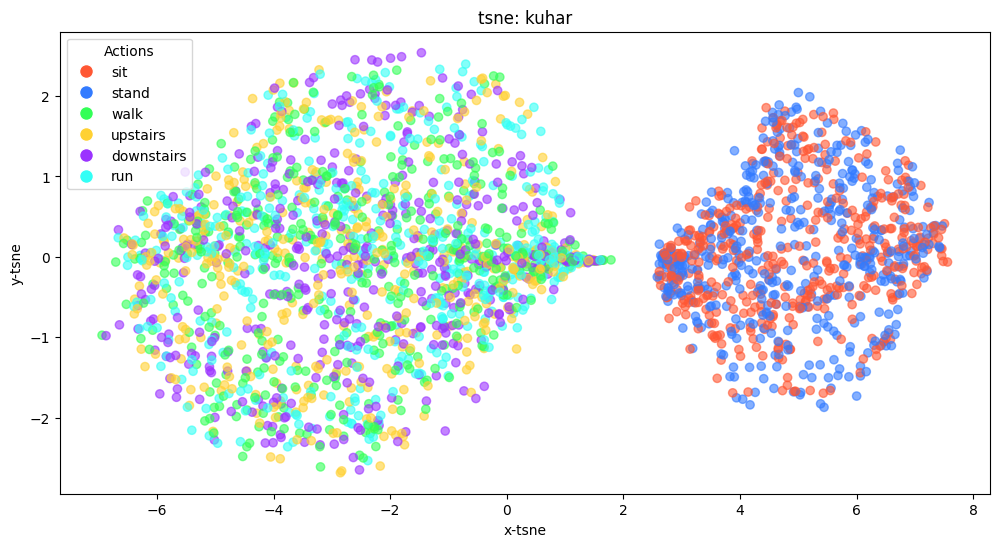

In [ ]:
TSNE_visualization(forward.cpu().detach().numpy(),labels, title = 'tsne: kuhar', show=True,
                   save_path='')

# Observing output

In [ ]:
class PatchEmbedding_Linear(nn.Module):
    #what are the proper parameters set here?
    def __init__(self, in_channels = 21, patch_size = 16, emb_size = 100, seq_len = 1024):
        # self.patch_size = patch_size
        super().__init__()
        #change the conv2d parameters here
        
        '''# Old projection with einops Rearrange function
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1 = 1, s2 = patch_size),
            nn.Linear(patch_size*in_channels, emb_size))
        '''
        self.projection = nn.Sequential(
            RearrangeLayer(patch_size=patch_size, s1=1),  #replace Rearrange from einops
            nn.Linear(patch_size * in_channels, emb_size))
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_len // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        #print(x.shape)
        b, _, _, _ = x.shape

        x = self.projection(x)
        #print(f'after Linear rearrange and  layer layer shape: {x.shape}')
        
        #print(f'\n cls_token initial shape: {self.cls_token.shape}')
        #cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        cls_tokens = self.cls_token.repeat(b, 1, 1) #Personal repeat from pytorch to transfer from einops

        #prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # position
        x += self.positions
        return x     
    
    #For use in change of Rearrange einops layer
class RearrangeLayer(nn.Module):
    def __init__(self, patch_size: int, s1: int = 1):
        super(RearrangeLayer, self).__init__()
        self.patch_size = patch_size
        self.s1 = s1

    def forward(self, x: Tensor) -> Tensor:
        b, c, h_s1, w_s2 = x.shape
        h, s1 = h_s1, self.s1
        w, s2 = w_s2 // self.patch_size, self.patch_size
        
        # Rearrange tensor
        x = x.view(b, c, h, s1, w, s2)  # shape: (b, c, h, s1, w, s2)
        x = x.permute(0, 2, 4, 3, 5, 1)  # shape: (b, h, w, s1, s2, c)
        x = x.reshape(b, h * w, s1 * s2 * c)  # shape: (b, h * w, s1 * s2 * c)  

        return x
        
class Encoder(nn.Sequential):
    def __init__(self, 
                 in_channels=3,
                 patch_size=15,
                 emb_size=50, 
                 seq_len = 150,
                 depth=3,  
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_len),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
        )

In [11]:
torch.manual_seed(0)
test_encoder = Encoder(in_channels=3, patch_size=15, emb_size=50, seq_len=30, depth=3)

In [12]:
torch.manual_seed(0)
print(f'data original shape in: {original_set[:5][0].shape}')
loggits = test_encoder(torch.from_numpy(original_set[:5][0]).float())
#loggits

data original shape in: (5, 3, 1, 30)


In [13]:
loggits

tensor([[[ 3.5807e-01, -7.9558e-01, -2.5969e+00,  2.0841e+00,  6.0064e-01,
          -9.2758e-01,  2.8175e+00, -1.4837e+00, -2.1722e-01, -1.8111e+00,
          -7.5698e-01,  1.6350e-01, -1.6082e+00, -4.8147e-01, -2.3117e+00,
           3.5922e-01,  9.7015e-01, -4.8995e-01,  1.6215e+00,  4.6503e-01,
          -1.9098e+00, -6.7315e-02,  1.1881e-02,  1.0475e+00,  1.5274e+00,
           1.7366e+00, -3.5397e-01, -8.5073e-01,  1.1612e+00, -1.4238e+00,
          -1.7933e+00,  8.5858e-01, -1.2986e+00, -1.0829e+00,  1.6530e+00,
           6.1738e-01, -1.1103e+00,  1.1588e+00, -6.9509e-01,  1.0833e+00,
           1.1844e+00, -2.0825e+00,  9.3405e-01,  5.5279e-01,  8.2286e-01,
           5.5792e-01, -1.8068e+00,  7.4520e-02,  3.0282e+00,  1.1325e+00],
         [-1.1964e+00,  6.3752e-02,  1.9341e-01,  1.2610e+00, -7.4656e-01,
          -2.2000e+00,  3.9445e+00, -2.2203e-01, -1.0758e+00,  3.1771e+00,
           1.7277e+00,  6.9678e-01, -2.2203e+00, -1.6145e+00, -1.0174e+00,
          -1.2398e+00, -

In [15]:
#lol  = loggits

In [14]:
np.array(lol == loggits).mean()

1.0

# Encoder Evaluation

In [ ]:
import re

# Função para converter até o primeiro número
def convert_string(s):
    # Encontrar a parte da string antes do primeiro número
    match = re.match(r'([^\d]+)(\d+)', s)
    if match:
        # Extrair a parte antes e o número
        prefix = match.group(1).lower()  # Parte antes do número, convertida para minúsculas
        number = match.group(2)          # Primeiro número encontrado
        return f"{prefix}{number}"       # Retorna no formato desejado
    return s  # Retorna a string original se não houver números

## 3axis seq_len 30 split dataset

In [ ]:
models_path = '../pre-trained-models/daghar_split_dataset/seq_len_30/3axis/'
data_path = '../DAGHAR_split_25_10/train/'
directorys = os.listdir(models_path)

first_parts = [item.split("Multiclass")[0] + "Multiclass" for item in directorys]
class_names = [item.split("_DAGHAR")[0] for item in directorys]
label_paths = [s.replace('DAGHAR', 'Label') for s in first_parts] 
directorys, class_names, first_parts, label_paths

In [ ]:
print('Starting Encoder Evaluation')
print('---------------------------------------------------------------------------------------')
for i in range(len(class_names)):
    Eval = EncoderEvaluation(
                 models_path = models_path + directorys[i] + '/Model/checkpoint',
                 class_name = class_names[i],
                 seq_len = 30,
                 channels = 3,
                 save_path = '../Notebooks/Encoder_View/split_dataset/seq_len_30/3axis/' ,
                 data_path = data_path + 'data/' + first_parts[i] + '.csv',
                 label_path = data_path + 'label/' + label_paths[i] + '.csv',
                 show=False)
    print('---------------------------------------------------------------------------------------')

## 6axis seq_len 30 split dataset

In [ ]:
models_path = '../pre-trained-models/daghar_split_dataset/seq_len_30/6axis/'
data_path = '../DAGHAR_split_25_10/train/'
directorys = os.listdir(models_path)

first_parts = [item.split("Multiclass")[0] + "Multiclass" for item in directorys]
class_names = [item.split("_DAGHAR")[0] for item in directorys]
label_paths = [s.replace('DAGHAR', 'Label') for s in first_parts] 
directorys, class_names, first_parts, label_paths

In [ ]:
print('Starting Encoder Evaluation')
print('---------------------------------------------------------------------------------------')
for i in range(len(class_names)):
    Eval = EncoderEvaluation(
                 models_path = models_path + directorys[i] + '/Model/checkpoint',
                 class_name = class_names[i],
                 seq_len = 30,
                 channels = 6,
                 save_path = '../Notebooks/Encoder_View/split_dataset/seq_len_30/6axis/' ,
                 data_path = data_path + 'data/' + first_parts[i] + '.csv',
                 label_path = data_path + 'label/' + label_paths[i] + '.csv',
                 show=False)
    print('---------------------------------------------------------------------------------------')

## 3axis seq_len 60 split dataset

In [ ]:
models_path = '../pre-trained-models/daghar_split_dataset/seq_len_60/3axis/'
data_path = '../DAGHAR_split_25_10/train/'
directorys = os.listdir(models_path)

first_parts = [item.split("Multiclass")[0] + "Multiclass" for item in directorys]
class_names = [item.split("_DAGHAR")[0] for item in directorys]
label_paths = [s.replace('DAGHAR', 'Label') for s in first_parts] 
directorys, class_names, first_parts, label_paths

In [ ]:
print('Starting Encoder Evaluation')
print('---------------------------------------------------------------------------------------')
for i in range(len(class_names)):
    Eval = EncoderEvaluation(
                 models_path = models_path + directorys[i] + '/Model/checkpoint',
                 class_name = class_names[i],
                 seq_len = 60,
                 channels = 3,
                 save_path = '../Notebooks/Encoder_View/split_dataset/seq_len_60/3axis/' ,
                 data_path = data_path + 'data/' + first_parts[i] + '.csv',
                 label_path = data_path + 'label/' + label_paths[i] + '.csv',
                 show=False)
    print('---------------------------------------------------------------------------------------')

Shape do resultado TSNE: (8748, 2)
---------------------------------------------------------------------------------------
class name : UCI
Data path is located in: ../DAGHAR_split_25_10/train/data/UCI_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/UCI_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/3axis/UCI_DAGHAR_Multiclass_50000_D_60_2024_10_25_15_53_51/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is UCI
data shape is (2420, 3, 1, 60)
label shape is (2420,)
1: torch.Size([2420, 3, 1, 60])
2: torch.Size([2420, 4, 50])
forward shape: (2420, 5, 50)
Shape após a média por canal: (2420, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (2420, 2)
---------------------------------------------------------------------------------------


## 6axis seq_len 60 split dataset

In [ ]:
models_path = '../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/'
data_path = '../DAGHAR_split_25_10/train/'
directorys = os.listdir(models_path)

first_parts = [item.split("Multiclass")[0] + "Multiclass" for item in directorys]
class_names = [item.split("_DAGHAR")[0] for item in directorys]
label_paths = [s.replace('DAGHAR', 'Label') for s in first_parts] 
directorys, class_names, first_parts, label_paths

(['KuHar_DAGHAR_Multiclass_50000_D_60_2024_10_30_03_01_46',
  'MotionSense_DAGHAR_Multiclass_50000_D_60_2024_10_30_00_07_49',
  'RealWorld_thigh_DAGHAR_Multiclass_50000_D_60_2024_10_30_00_43_14',
  'UCI_DAGHAR_Multiclass_50000_D_60_2024_10_30_01_50_17',
  'WISDM_DAGHAR_Multiclass_50000_D_60_2024_10_30_01_16_54',
  'RealWorld_waist_DAGHAR_Multiclass_50000_D_60_2024_10_30_02_28_08'],
 ['KuHar',
  'MotionSense',
  'RealWorld_thigh',
  'UCI',
  'WISDM',
  'RealWorld_waist'],
 ['KuHar_DAGHAR_Multiclass',
  'MotionSense_DAGHAR_Multiclass',
  'RealWorld_thigh_DAGHAR_Multiclass',
  'UCI_DAGHAR_Multiclass',
  'WISDM_DAGHAR_Multiclass',
  'RealWorld_waist_DAGHAR_Multiclass'],
 ['KuHar_Label_Multiclass',
  'MotionSense_Label_Multiclass',
  'RealWorld_thigh_Label_Multiclass',
  'UCI_Label_Multiclass',
  'WISDM_Label_Multiclass',
  'RealWorld_waist_Label_Multiclass'])

In [ ]:
print('Starting Encoder Evaluation')
print('---------------------------------------------------------------------------------------')
for i in range(len(class_names)):
    Eval = EncoderEvaluation(
                 models_path = models_path + directorys[i] + '/Model/checkpoint',
                 class_name = class_names[i],
                 seq_len = 60,
                 channels = 6,
                 save_path = '../Notebooks/Encoder_View/split_dataset/seq_len_60/6axis/' ,
                 data_path = data_path + 'data/' + first_parts[i] + '.csv',
                 label_path = data_path + 'label/' + label_paths[i] + '.csv',
                 show=False)
    print('---------------------------------------------------------------------------------------')

Starting Encoder Evaluation
---------------------------------------------------------------------------------------
class name : KuHar
Data path is located in: ../DAGHAR_split_25_10/train/data/KuHar_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/KuHar_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/KuHar_DAGHAR_Multiclass_50000_D_60_2024_10_30_03_01_46/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is KuHar
data shape is (1392, 6, 1, 60)
label shape is (1392,)
1: torch.Size([1392, 6, 1, 60])
2: torch.Size([1392, 4, 50])
forward shape: (1392, 5, 50)
Shape após a média por canal: (1392, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (1392, 2)
---------------------------------------------------------------------------------------
class name : MotionSense
Data path is located in: ../DAGHAR_split_25_10/train/data/MotionSense_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/MotionSense_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/MotionSense_DAGHAR_Multiclass_50000_D_60_2024_10_30_00_07_49/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is MotionSense
data shape is (3558, 6, 1, 60)
label shape is (3558,)
1: torch.Size([3558, 6, 1, 60])
2: torch.Size([3558, 4, 50])
forward shape: (3558, 5, 50)
Shape após a média por canal: (3558, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (3558, 2)
---------------------------------------------------------------------------------------
class name : RealWorld_thigh
Data path is located in: ../DAGHAR_split_25_10/train/data/RealWorld_thigh_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/RealWorld_thigh_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/RealWorld_thigh_DAGHAR_Multiclass_50000_D_60_2024_10_30_00_43_14/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is RealWorld_thigh
data shape is (10338, 6, 1, 60)
label shape is (10338,)
1: torch.Size([10338, 6, 1, 60])
2: torch.Size([10338, 4, 50])
forward shape: (10338, 5, 50)
Shape após a média por canal: (10338, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (10338, 2)
---------------------------------------------------------------------------------------
class name : UCI
Data path is located in: ../DAGHAR_split_25_10/train/data/UCI_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/UCI_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/UCI_DAGHAR_Multiclass_50000_D_60_2024_10_30_01_50_17/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is UCI
data shape is (2420, 6, 1, 60)
label shape is (2420,)
1: torch.Size([2420, 6, 1, 60])
2: torch.Size([2420, 4, 50])
forward shape: (2420, 5, 50)
Shape após a média por canal: (2420, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (2420, 2)
---------------------------------------------------------------------------------------
class name : WISDM
Data path is located in: ../DAGHAR_split_25_10/train/data/WISDM_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/WISDM_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/WISDM_DAGHAR_Multiclass_50000_D_60_2024_10_30_01_16_54/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is WISDM
data shape is (8748, 6, 1, 60)
label shape is (8748,)
1: torch.Size([8748, 6, 1, 60])
2: torch.Size([8748, 4, 50])
forward shape: (8748, 5, 50)
Shape após a média por canal: (8748, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (8748, 2)
---------------------------------------------------------------------------------------
class name : RealWorld_waist
Data path is located in: ../DAGHAR_split_25_10/train/data/RealWorld_waist_DAGHAR_Multiclass.csv
Label path is located in: ../DAGHAR_split_25_10/train/label/RealWorld_waist_Label_Multiclass.csv
Models path is located in: ../pre-trained-models/daghar_split_dataset/seq_len_60/6axis/RealWorld_waist_DAGHAR_Multiclass_50000_D_60_2024_10_30_02_28_08/Model/checkpoint
dataset: Daghar
 
 Starting Encoder Evaluation
Original Set:
return single class data and labels, class is RealWorld_waist
data shape is (10332, 6, 1, 60)
label shape is (10332,)
1: torch.Size([10332, 6, 1, 60])
2: torch.Size([10332, 4, 50])
forward shape: (10332, 5, 50)
Shape após a média por canal: (10332, 50)


/workspaces/container-workspace/tts-gan/Notebooks/EvaluationFunctions.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(self.models_path, map_location=t

Shape do resultado TSNE: (10332, 2)
---------------------------------------------------------------------------------------
